In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import file
df = pd.read_csv('trade_logistic_regression.csv')
df.head()

,ETH_7D_PRC_CHG,BTC_7D_PRC_CHG,R12_CRYPTO_TRADES,AGE,TENURE,CRYPTO_ASSETS,GENDER,STATE,CALENDAR_DAY_WEEK_NBR,CALENDAR_WEEK_NBR,TTL_RETAIL_BROKERAGE_ASSETS,TRADED
0,5,1,0,39.8,1.2,0.0,UNKNOWN,AE,7,39,0.0,0
1,0,2,0,39.8,1.2,0.0,UNKNOWN,AE,5,38,0.0,0
2,-4,-3,0,42.3,3.4,0.0,MALE,AL,1,30,0.0,0
3,0,3,0,42.3,3.5,0.0,MALE,AL,5,35,0.0,0
4,0,-3,0,57.9,0.7,0.0,MALE,AL,3,6,0.0,0


In [291]:
# create dummy variables 
from sklearn.preprocessing import OneHotEncoder
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
encoder = OneHotEncoder()
one_hot_encoded = encoder.fit_transform(df[categorical_columns])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))
df_encoded=pd.concat([df,one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_columns, axis=1)

df_encoded.head()

ValueError: Shape of passed values is (1000000, 1), indices imply (1000000, 65)

In [242]:
# import scikit-learn packages
# set up X and y parameters for model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# independent and dependent variables
X = df.drop(columns=["TRADED"], axis=1)
y = df["TRADED"]

print(X.shape)
print(y.shape)

(1000000, 74)
(1000000,)


In [259]:
# scale the data to remove extremes
# impute data to fill in NaN values
steps = [('imputation', SimpleImputer(missing_values=np.nan, strategy='mean')),
         ('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]

pipeline = Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=False)
# Fit and transform X_train
X_train_imputed = imp.fit_transform(X_train)

# Transform X_test
X_test_imputed = imp.transform(X_test)

logreg_scaled = pipeline.fit(X_train_imputed, y_train)
y_pred = logreg_scaled.predict(X_test_imputed)

# show accuracy score (true positive + negative / all samples)
print(logreg_scaled.score(X_test_imputed, y_test))

0.98806


In [119]:
#show confusion matrix, classification report
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[296326     94]
 [  3472    108]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    296420
           1       0.53      0.03      0.06      3580

    accuracy                           0.99    300000
   macro avg       0.76      0.51      0.53    300000
weighted avg       0.98      0.99      0.98    300000



0.7422977994630722


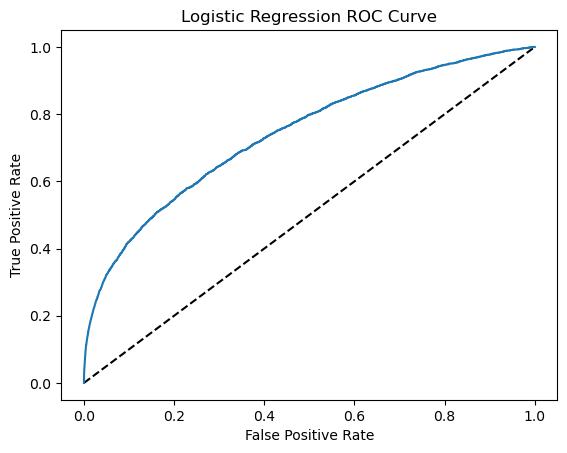

In [177]:
# plot ROC curve and value
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_probs = logreg_scaled.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
print(roc_auc_score(y_test, y_pred_probs))
plt.show()

In [309]:
# reverse one-hot encoding in X_test set
X_test_imputed_df = pd.DataFrame(X_test_imputed, columns=df_encoded.drop(columns=["TRADED"], axis=1).columns)
one_hot_columns = encoder.get_feature_names_out(categorical_columns)
X_test_one_hot = X_test_imputed_df.loc[:,one_hot_columns]
X_reversed = pd.DataFrame(encoder.inverse_transform(X_test_one_hot), columns=categorical_columns)
X_reversed.head()

,GENDER,STATE
0,MALE,TX
1,MALE,MA
2,MALE,VT
3,MALE,MD
4,MALE,NE


In [313]:
# merge reversed one-hot columns with original X_test set
X_test_numeric = X_test_imputed_df.drop(columns=one_hot_columns)
X_test_orig = X_test_numeric.merge(X_reversed, left_index=True, right_index=True)
X_test_orig.head()

,ETH_7D_PRC_CHG,BTC_7D_PRC_CHG,R12_CRYPTO_TRADES,AGE,TENURE,CRYPTO_ASSETS,CALENDAR_DAY_WEEK_NBR,CALENDAR_WEEK_NBR,TTL_RETAIL_BROKERAGE_ASSETS,GENDER,STATE
0,5.0,5.0,0.0,43.6,5.8,0.00,3.0,40.0,0.00,MALE,TX
1,-3.0,5.0,0.0,23.8,0.8,3.17,2.0,2.0,1.31,MALE,MA
2,0.0,1.0,0.0,27.3,5.6,647.19,4.0,32.0,33318.36,MALE,VT
3,17.0,18.0,1.0,35.8,11.3,0.00,5.0,9.0,17836.70,MALE,MD
4,-1.0,0.0,0.0,35.6,0.4,489.89,3.0,35.0,0.17,MALE,NE


In [324]:
# merge y_pred onto X_test data frame
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.rename(columns={0: 'y_predicted'}, inplace=True)

X_test_final = X_test_orig.merge(y_pred_df, left_index=True, right_index=True)
X_test_final.head()

# send results into a CSV for further analysis / entry into database
X_test_final.to_csv('logistic_regression_results.csv')